In [596]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("Dates")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [597]:
using CSV,DataFrames

# Reading the csv file into a dataframe along with omitting the first data description lines. 
Data = CSV.read("dow_jones_index.csv",normalizenames = true,header = false,skipto = 3,DataFrame)

size(Data)

(750, 6)

In [598]:
# Normalizing the Data
Data_copy = copy(Data)
for k in propertynames(Data_copy)
  col_max = maximum(Data_copy[:,k])
  col_min = minimum(Data_copy[:,k])
  Data_copy[!,k] = [(i - col_min)/(col_max - col_min) for i in Data_copy[:,k]]
end
first(Data_copy,5)


Row,Column1,Column2,Column3,Column4,Column5,Column6
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0355474,0.0341761,0.159267,0.759355,0.077381,0.0781579
2,0.0354859,0.0332867,0.161558,0.434474,0.0565476,0.081593
3,0.0334563,0.0330327,0.0891514,0.511842,0.0357143,0.0830223
4,0.0349938,0.0344302,0.0981218,0.674219,0.014881,0.0803499
5,0.0396679,0.0367171,0.100206,0.843945,0.28869,0.0730365


In [599]:
println("Number Of Clusters :")
s = readline()
N = parse(Int,s)

Number Of Clusters :
stdin> 4


4

In [600]:
# Generate the N random centroids
using Dates 
t_1 = now()
indices = rand(1:nrow(Data_copy),N)
println(indices)

x = [Array(Data_copy[i,:]) for i in indices]

[215, 1, 161, 491]


4-element Vector{Vector{Float64}}:
 [0.3300738007380074, 0.3232753144454326, 0.03451092269714045, 0.5087482261501918, 0.25892857142857145, 0.456433122328154]
 [0.03554735547355473, 0.03417608944225638, 0.15926689300181568, 0.7593547237259797, 0.07738095238095238, 0.07815786112733697]
 [0.06623616236162362, 0.06752636259687461, 0.1858048945714111, 0.633316169488163, 0.2648809523809524, 0.510253389047989]
 [0.16562115621156212, 0.16656079278363614, 0.02989671427846357, 0.6200264926518853, 0.22023809523809523, 0.4003828280672787]

In [601]:
function distance(vec1,vec2)
    sum = 0.0
    for i in 1 : length(vec1)
     sum = sum + (vec1[i] - vec2[i])^2
    end
    sum = sqrt(sum)
    return sum
end

function J_clust_k(Data,k,μ)
    sum = 0.0
    counts = 0
   for i in 1 : nrow(Data)
        if Data[i,end] == k
          sum += distance(Array(Data[i,1:end-1]),μ[k])^2
          counts +=1
        end
   end
   loss = (sum)/(counts)
   return loss
end 

function J_clust(Data,μ)
    total_loss = 0
    for i in 1 : length(μ)
        total_loss += J_clust_k(Data,i,μ)
    end
    return total_loss        
end

J_clust (generic function with 1 method)

In [602]:
distances = []
min_arr = [10000.0 1]

n_row = nrow(Data_copy)

Data_copy[!,:Cluster_no] = rand(1:N,n_row)

n_col = ncol(Data_copy)

iter = 0

max_iter = 100

J = zeros(max_iter+1,1)
J[1] = J_clust(Data_copy,x) 
for i in 1 : max_iter
 for i in 1 : n_row
    for j in 1 : N
         k = distance(Array(Data_copy[i,1:n_col-1]),x[j])
         push!(distances,k)
         if min_arr[1] - distances[j] > 1e-6
                 min_arr[1] = distances[j]
                 min_arr[1,2] = j
         end
    end
     Data_copy[i,n_col] = Int(min_arr[1,2])

     distances = []
     min_arr = [10000.0 1]
        
 end
 
 counts = zeros(N)
  x = zeros(N,n_col-1)

  for i in 1 : n_row 
     Cluster_ID = Data_copy[i,:Cluster_no]
     x[Cluster_ID,:]  = x[Cluster_ID,:] .+ Array(Data_copy[i,1:n_col-1])
     counts[Cluster_ID] +=1
  end


  for j in 1 : N
     x[j,:] = x[j,:]/counts[j]
  end 
     iter +=1
    x = [x[j,:] for j in 1 : N]
    J[i+1] = J_clust(Data_copy,x)
    
    if abs(J[i] - J[i+1]) < 1e-6
        break
    end
    
# println(J_clust(Data_copy,x))
end 
t_2 = now()

2022-12-05T19:30:20.481

In [603]:
println("Number of Iterations required to converge : ",iter)

for i in 1 : N
    println("Number of vectors in Cluster ",i ," are : ",counts[i])
end

println("Run time of the Program :",t_2-t_1)

Number of Iterations required to converge : 19
Number of vectors in Cluster 1 are : 123.0
Number of vectors in Cluster 2 are : 149.0
Number of vectors in Cluster 3 are : 175.0
Number of vectors in Cluster 4 are : 303.0
Run time of the Program :527 milliseconds


In [604]:
Data[!,:Cluster_no] = Data_copy[!,:Cluster_no]

CSV.write("output.csv",Data)


"output.csv"

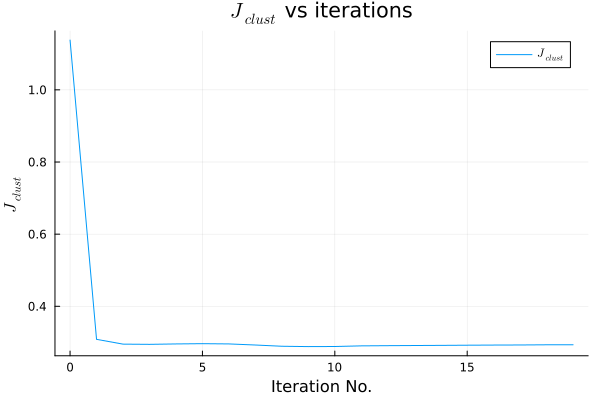

In [605]:
using Plots
using LaTeXStrings
 x = [0:iter]
 y = [J[i] for i in 1:iter+1]
 plot(x,y,title = L"$J_{clust}$ vs iterations",label = L"J_{clust}")
 xlabel!("Iteration No.")
 ylabel!(L"J_{clust}")
